# TODO additional columns
- NLP title processing ideas
 - ~is it a question?~ 
 - ~sentiment analysis~
 - ~how many verbs does the title have?~
 - ~how many words does the title have?~
 - ~how many characters does the title have?~
 - ~amount of adjectives~   
 - ~amount of nouns~
 - ~word popularity score~
 - ~2-gram popularity score~
 - remove stop words
 - ~transform words to base form~
- others
 - ~ohe months~

In [6]:
!pip install catboost
!pip install nltk
!pip install twython
!pip install scikit-optimize
!pip install ktrain
!pip install tensorflow

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached h5py-2.10.0-cp38-cp38-win_amd64.whl (2.5 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached grpcio-1.32.0-cp38-cp38-win_amd64.whl (2.6 MB)
  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached absl_py-0.11.0-py3-none-any.whl (127 kB)
  Using cached google_auth_oauthlib-0.4.2-py2.py3-none-any.whl (18 kB)
  Using cached Werkzeug-1.0.1-py2.py3-no

ERROR: Could not install packages due to an OSError: [WinError 5] Odmowa dostępu: 'C:\\Users\\jacek\\Documents\\ML Project\\venv\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [1]:
import nltk
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('universal_tagset')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jacek\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jacek\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jacek\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacek\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\jacek\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score 
from skopt import BayesSearchCV, Space
from skopt.space import Real, Categorical, Integer
from ktrain import text

In [9]:
# Preparing raw input data for a concat
columns2016 = ['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd_pledged', 
               'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']
columns2018 = ['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd_pledged', 
               'usd_pledged_real', 'usd_goal_real']

use_cols = ['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd_pledged']

data2016 = pd.read_csv("https://raw.githubusercontent.com/kolacz/university_ml_project/master/ks-projects-201612.csv", encoding='cp1252', 
                       header=0, names=columns2016, usecols=use_cols)
data2018 = pd.read_csv("https://raw.githubusercontent.com/kolacz/university_ml_project/master/ks-projects-201801.csv",
                       header=0, names=columns2018, usecols=use_cols)

In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/kolacz/university_ml_project/master/ks-projects-201801.csv",
                 header=0, names=columns2018)
print(df.shape)
df.head()

(378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Nie warto mergować, bo:

In [11]:
print(len(set(data2016['name']).intersection(data2018['name'])))
print(len(set(data2016['ID']).intersection(data2018['ID'])))
print(len(set(data2016['goal']).intersection(data2018['goal'])))
print(data2016.shape)
print(data2018.shape)
data2018.head()

321004
323750
0
(323750, 13)
(378661, 13)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0


In [12]:
data2016.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375



# TODOs (data preprocessing):
- ~remove rows, for which categories are messed up (probably commas in names have shifted everything)~
- ~one-hot encode `main_category` and `country`~
- (?) ~create labels for `category` columns~
- ~create a feature with active days (given `launched` and `deadline`)~
- (?) fill `NaN`s (check if there are any)
- ~change all un-`successful` states into `failed`~
- (?) ~convert the `goal` with `currency` to a new column - `usd_goal` (fixer.io api may come in handy)~
- (?) ~add features based on date columns: month / year / season~
- normalize/standardize data (I don't think there are any columns which we could really normalize - Jacek)
- ~ohe everything~
- ~make a stratified split to train~ / validation / ~test~
- make settings to allow control over which preprocessing changes we allow (so we don't have to go over the entire code each time we want to change the data model)
- additonal data presentation (ex. a plot presenting how the success ratio changes with the length of the title)

#Data preprocessing

## Time / Category / Countries

In [ ]:
# # looking at shifted data
# print(df[df["deadline"].apply(len) == 3].shape)  # shifted >> 1
# print(df[df["goal"].apply(lambda x: all(map(str.isalpha, str(x))))].shape) # shifted >> 2 and more

# df[df["goal"].apply(lambda x: all(map(str.isalpha, str(x))))]

In [13]:
# droping ID
df = df.drop("ID", axis=1)

In [14]:
# adding "days_to_deadline" attribute
df[["launched", "deadline"]] = df[["launched", "deadline"]].apply(pd.to_datetime)
df["days_to_deadline"] = (df["deadline"] - df["launched"]).dt.days

In [15]:
# checking how the categories look like
df['category'].unique()
# probably one-hot encoding isn't a way to choose - maybe we could just encode categoricals into indexes/labels

array(['Poetry', 'Narrative Film', 'Music', 'Film & Video', 'Restaurants',
       'Food', 'Drinks', 'Product Design', 'Documentary', 'Nonfiction',
       'Indie Rock', 'Crafts', 'Games', 'Tabletop Games', 'Design',
       'Comic Books', 'Art Books', 'Fashion', 'Childrenswear', 'Theater',
       'Comics', 'DIY', 'Webseries', 'Animation', 'Food Trucks',
       'Public Art', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Family', 'Fiction', 'Accessories', 'Rock', 'Hardware',
       'Software', 'Weaving', 'Gadgets', 'Web', 'Jazz', 'Ready-to-wear',
       'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Electronic Music', 'Radio & Podcasts', 'Apps', 'Cookbooks',
       'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
       'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
       'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
       'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
       

In [16]:
# how do countries look like?
df["country"].unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'N,0"',
       'SE', 'FR', 'NL', 'NZ', 'CH', 'AT', 'DK', 'BE', 'HK', 'LU', 'SG',
       'JP'], dtype=object)

In [18]:
# checking what data includes bizarre 'N,"0'/'N,0"' countries and if we can drop it
print(df[df["country"].isin(['N,"0', 'N,0"'])].shape)
df[df["country"].isin(['N,"0', 'N,0"'])]["deadline"].max()

(3797, 15)


Timestamp('2016-07-07 00:00:00')

In [19]:
# yes, we can!
df = df[~df["country"].isin(['N,"0', 'N,0"'])]

In [20]:
# making new columns based on months over which the projects spanned
df['launch_month'] = pd.DatetimeIndex(df['launched']).month
df['deadline_month'] = pd.DatetimeIndex(df['deadline']).month

months = pd.DatetimeIndex(df['launched']).month
days = pd.DatetimeIndex(df['launched']).day
date_offset = (months*100 + days - 320)%1300
df['launch_season'] = pd.cut(date_offset, [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

months = pd.DatetimeIndex(df['deadline']).month
days = pd.DatetimeIndex(df['deadline']).day
date_offset = (months*100 + days - 320)%1300
df['deadline_season'] = pd.cut(date_offset, [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df['launch_season'] = df['launch_season'].astype(str)
df['deadline_season'] = df['deadline_season'].astype(str)

df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,days_to_deadline,launch_month,deadline_month,launch_season,deadline_season
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58,8,10,summer,autumn
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59,9,11,summer,autumn
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44,1,2,winter,winter
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29,3,4,winter,spring
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,55,7,8,summer,summer


## Title statistics

In [21]:
# fixing empty titles
df['name'] = df['name'].astype(str)
df['name'] = df['name'].fillna("Empty")

In [22]:
# counting total characters
title_characters = []

for title in df['name']:
    title_characters.append(len(title))

df['title_length_characters'] = title_characters

In [23]:
# counting name length
title_length = []

for title in df['name']:
    title_length.append(len(title.split()))
    
df['title_length_words'] = title_length

In [24]:
# counting exclamations and question marks
exc = []
ques = []

for title in df['name']:
    if '!' in title:
        exc.append(1)
    else:
        exc.append(0)
    if '?' in title:
        ques.append(1)
    else:
        ques.append(0)

df['exclamation'] = exc
df['question'] = ques

In [25]:
# counting verbs, adjectives and nouns
verbs = []
adjs = []
nouns = []

for title in df['name']:
    tokens = nltk.word_tokenize(title)
    tokens = nltk.pos_tag(tokens, tagset='universal')
    vc = 0
    ac = 0
    nc = 0
    for token in tokens:
        if token[1] == 'NOUN':
            nc += 1
        if token[1] == 'VERB':
            vc += 1
        if token[1] == 'ADJ':
            ac += 1
    verbs.append(vc)
    adjs.append(ac)
    nouns.append(nc)

df['verbs'] = verbs
df['adjs'] = adjs
df['nouns'] = nouns

In [32]:
data_train = pd.read_csv('data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data_test.csv', encoding='utf-8')

X_train = data_train.Text.tolist()
X_test = data_test.Text.tolist()

y_train = data_train.Emotion.tolist()
y_test = data_test.Emotion.tolist()

data = data_train.append(data_test, ignore_index=True)

class_names = ['joy', 'sadness', 'fear', 'anger', 'neutral']

print('size of training set: %s' % (len(data_train['Text'])))
print('size of validation set: %s' % (len(data_test['Text'])))
print(data.Emotion.value_counts())

data.head(10)

size of training set: 7934
size of validation set: 3393
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...
6,joy,Finding out I am chosen to collect norms for C...
7,anger,A spokesperson said : ` Glen is furious that t...
8,neutral,Yes .
9,sadness,"When I see people with burns I feel sad, actua..."


In [33]:
encoding = {
    'joy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'neutral': 4
}

# Integer values for each class
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

In [34]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350, 
                                                                       max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en
Is Multi-Label? False
preprocessing test...
language: en
task: text classification


In [35]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350
done.


In [36]:
import ktrain
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)

In [37]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
1323/1323 [==============================] - 18051s 14s/step - loss: 1.1908 - accuracy: 0.5262 - val_loss: 0.5626 - val_accuracy: 0.8014

In [38]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['joy', 'sadness', 'fear', 'anger', 'neutral']

In [44]:
prediction = predictor.predict("Please help me")
print(prediction)

fear


In [42]:
predictor.save("bert_model")

In [43]:
import ktrain
predictor = ktrain.load_predictor("bert_model")

In [ ]:
# using sentiment analysis to rate project names
sia = SIA()
results = {}

i = 0
for title in df['name']:
    pol_score = sia.polarity_scores(title)
    for cat in pol_score:
        if cat not in results:
            results[cat] = []
        results[cat].append(pol_score[cat])
    i += 1

for cat in results:
    df[cat] = results[cat]

df.head()

In [ ]:
# counting unigrams and digrams
unigrams = {}
total_uni = 0
digrams = {}
total_di = 0

lemmatizer = WordNetLemmatizer() 

for title in df["name"]:
    tokens = nltk.word_tokenize(title)
    phrase = []
    for token in tokens:
        token = lemmatizer.lemmatize(token).lower()
        if token.isalnum():
            phrase.append(token)

    for word in phrase:
        if word not in unigrams:
            unigrams[word] = 0
        unigrams[word] += 1
        total_uni += 1

    for i in range(1,len(phrase)):
        if phrase[i-1] not in digrams:
            digrams[phrase[i-1]] = {}
        if phrase[i] not in digrams[phrase[i-1]]:
            digrams[phrase[i-1]][phrase[i]] = 0
        digrams[phrase[i-1]][phrase[i]] += 1
        total_di += 1

In [ ]:
# word popularity score
uni_score = []
di_score = []

for title in df["name"]:
    tokens = nltk.word_tokenize(title)
    phrase = []
    for token in tokens:
        token = lemmatizer.lemmatize(token).lower()
        if token.isalnum():
            phrase.append(token)
    
    uni = 0
    for word in phrase:
        uni += unigrams[word]
    if len(phrase) > 0:
        uni /= len(phrase)

    di = 0
    for i in range(1,len(phrase)):
        di += digrams[phrase[i-1]][phrase[i]]
    if len(phrase)-1 > 0:
        di /= len(phrase)-1
    
    uni_score.append(uni)
    di_score.append(di)

df['uni_score'] = uni_score
df['di_score'] = di_score

In [ ]:
df.head()

## Goal transformation

In [ ]:
# changing all unsuccessful states into failed
names = df['state'].unique()
names = np.delete(names, np.where(names == 'successful'))
df = df.replace(names, value = 'failed')
df['state'].unique()

array(['failed', 'successful'], dtype=object)

In [ ]:
# testing to see if you can win without reaching the money goal
failed_goal = (np.array(df["pledged"]) < np.array(df["goal"]))
success = (np.array(df["state"]) == "successful")
wierd_success = []
for i in range(len(success)):
    if failed_goal[i] == True and success[i] == True:
        wierd_success.append(i)
print(len(wierd_success))
df.iloc[wierd_success]

5


,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,days_to_deadline,launch_month,deadline_month,launch_season,deadline_season,title_length_characters,title_length_words,exclamation,question,verbs,adjs,nouns
72483,Santa's Sled,Art,Art,USD,2012-08-27,3600.0,2012-07-26 03:31:28,3599.69,successful,64,US,3599.69,3599.69,3600.00,31,7,8,summer,summer,12,2,0,0,0,0,2
151490,Borders of the Imagination - An Epic Sci-Fi/Fa...,Shorts,Film & Video,USD,2015-12-27,36000.0,2015-11-12 19:06:18,30716.00,successful,275,US,30716.00,30716.00,36000.00,44,11,12,autumn,winter,57,9,0,0,0,0,5
232422,Documentary film about Les Blank.,Documentary,Film & Video,USD,2010-07-18,8000.0,2010-06-02 22:15:38,7999.65,successful,73,US,7999.65,7999.65,8000.00,45,6,7,spring,summer,33,5,0,0,0,0,4
275777,Insiders/Out: Exploring Outsider Art in America,Art,Art,USD,2010-07-08,2000.0,2010-05-27 00:26:33,1999.66,successful,30,US,1999.66,1999.66,2000.00,41,5,7,spring,summer,47,6,0,0,0,0,5
335859,TUW Ruhla Watches - Comeback of a Legend,Product Design,Design,EUR,2016-03-19,25000.0,2016-02-08 19:14:02,24892.50,successful,90,DE,27778.24,27765.07,27884.98,39,2,3,winter,winter,40,8,0,0,0,0,5


In [ ]:
# new success definiton - a project is considered successful if it pledged at least as much money as was stated in it's goal
change_goal = True
if change_goal:
    pledged = np.array(df["pledged"]) >= np.array(df["goal"])
    new_success = []
    for i in range(len(success)):
        if pledged[i] == True:
            new_success.append(1)
        else:
            new_success.append(0)
    new_success = np.array(new_success)
    print(np.unique(new_success, return_counts=True))
    df["state"] = new_success

df["state"].value_counts()

(array([0, 1]), array([239582, 135282]))


0    239582
1    135282
Name: state, dtype: int64

## Encoding / Prototype creation

In [ ]:
# label-encoding of `category` column
label_encoder = LabelEncoder()
df['category_n'] = label_encoder.fit_transform(df['category'])
df_labeled = df.drop("category", axis=1)
df_labeled
# it doesn't look good... probably skipping the whole column will be better than the labeling, but let's discuss it

,name,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,days_to_deadline,launch_month,deadline_month,launch_season,deadline_season,title_length_characters,title_length_words,exclamation,question,verbs,adjs,nouns,category_n
0,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,58,8,10,summer,autumn,31,6,0,0,0,0,3,108
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,59,9,11,summer,autumn,45,8,0,0,1,0,5,93
2,Where is Hank?,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,44,1,2,winter,winter,14,3,0,1,1,0,1,93
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,29,3,4,winter,spring,49,7,0,0,1,1,4,90
4,Community Film Project: The Art of Neighborhoo...,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,US,1283.0,1283.0,19500.00,55,7,8,summer,summer,58,8,0,0,0,0,6,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,ChknTruk Nationwide Charity Drive 2014 (Canceled),Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,0,1,US,25.0,25.0,50000.00,29,9,10,summer,autumn,49,6,0,0,1,0,4,39
378657,The Tribe,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,US,155.0,155.0,1500.00,26,6,7,summer,summer,9,2,0,0,0,0,1,93
378658,Walls of Remedy- New lesbian Romantic Comedy f...,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,US,20.0,20.0,15000.00,45,7,8,summer,summer,71,11,1,0,0,3,5,93
378659,BioDefense Education Kit,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,0,6,US,200.0,200.0,15000.00,30,1,2,winter,winter,24,3,0,0,0,0,3,138


In [ ]:
# the one-hot encoding
df_ohe = pd.get_dummies(df_labeled, columns=["main_category", "country", "launch_season", "deadline_season"])
df_ohe

,name,currency,deadline,goal,launched,pledged,state,backers,usd_pledged,usd_pledged_real,usd_goal_real,days_to_deadline,launch_month,deadline_month,title_length_characters,title_length_words,exclamation,question,verbs,adjs,nouns,category_n,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,launch_season_autumn,launch_season_nan,launch_season_spring,launch_season_summer,launch_season_winter,deadline_season_autumn,deadline_season_nan,deadline_season_spring,deadline_season_summer,deadline_season_winter
0,The Songs of Adelaide & Abullah,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,0.0,0.0,1533.95,58,8,10,31,6,0,0,0,0,3,108,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,100.0,2421.0,30000.00,59,9,11,45,8,0,0,1,0,5,93,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
2,Where is Hank?,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,220.0,220.0,45000.00,44,1,2,14,3,0,1,1,0,1,93,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,ToshiCapital Rekordz Needs Help to Complete Album,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,1.0,1.0,5000.00,29,3,4,49,7,0,0,1,1,4,90,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
4,Community Film Project: The Art of Neighborhoo...,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,1283.0,1283.0,19500.00,55,7,8,58,8,0,0,0,0,6,55,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,ChknTruk Nationwide Charity Drive 2014 (Canceled),USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,0,1,25.0,25.0,50000.00,29,9,10,49,6,0,0,1,0,4,39,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
378657,The Tribe,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,155.0,155.0,1500.00,26,6,7,9,2,0,0,0,0,1,93,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
378658,Walls of Remedy- New lesbian Romantic Comedy f...,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,20.0,20.0,15000.00,45,7,8,71,11,1,0,0,3,5,93,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
378659,BioDefense Education Kit,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,0,6,200.0,200.0,15000.00,30,1,2,24,3,0,0,0,0,3,138,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


In [ ]:
# one-hot encoding for everything
df_ohe2 = pd.get_dummies(df_labeled, columns=["currency", "category_n", "main_category", "country", "launch_month", "launch_season", "deadline_month", "deadline_season"])
df_ohe2

,name,deadline,goal,launched,pledged,state,backers,usd_pledged,usd_pledged_real,usd_goal_real,days_to_deadline,title_length_characters,title_length_words,exclamation,question,verbs,adjs,nouns,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,category_n_0,category_n_1,category_n_2,category_n_3,category_n_4,category_n_5,category_n_6,category_n_7,...,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,launch_month_1,launch_month_2,launch_month_3,launch_month_4,launch_month_5,launch_month_6,launch_month_7,launch_month_8,launch_month_9,launch_month_10,launch_month_11,launch_month_12,launch_season_autumn,launch_season_nan,launch_season_spring,launch_season_summer,launch_season_winter,deadline_month_1,deadline_month_2,deadline_month_3,deadline_month_4,deadline_month_5,deadline_month_6,deadline_month_7,deadline_month_8,deadline_month_9,deadline_month_10,deadline_month_11,deadline_month_12,deadline_season_autumn,deadline_season_nan,deadline_season_spring,deadline_season_summer,deadline_season_winter
0,The Songs of Adelaide & Abullah,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,0.0,0.0,1533.95,58,31,6,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,100.0,2421.0,30000.00,59,45,8,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,Where is Hank?,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,220.0,220.0,45000.00,44,14,3,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,ToshiCapital Rekordz Needs Help to Complete Album,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,1.0,1.0,5000.00,29,49,7,0,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Community Film Project: The Art of Neighborhoo...,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,1283.0,1283.0,19500.00,55,58,8,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,ChknTruk Nationwide Charity Drive 2014 (Canceled),2014-10-17,50000.0,2014-09-17 02:35:30,25.0,0,1,25.0,25.0,50000.00,29,49,6,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
378657,The Tribe,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,155.0,155.0,1500.00,26,9,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
378658,Walls of Remedy- New lesbian Romantic Comedy f...,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,20.0,20.0,15000.00,45,71,11,1,0,0,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
378659,BioDefense Education Kit,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,0,6,200.0,200.0,15000.00,30,24,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# dropping some important features just to create a prototype
df_preprocessed = df_ohe.drop(["name", "currency", "deadline", "launched", "pledged", "usd_pledged", "usd_pledged_real", "backers"], axis=1).reset_index(drop=True)
df_preprocessed["goal"] = pd.to_numeric(df_preprocessed["goal"])
#df_preprocessed["state"] = df_preprocessed["state"].astype("string")
y = df_preprocessed["state"]
X = df_preprocessed.drop("state", axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=420)

In [ ]:
X_train

,goal,usd_goal_real,days_to_deadline,launch_month,deadline_month,title_length_characters,title_length_words,exclamation,question,verbs,adjs,nouns,category_n,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,launch_season_autumn,launch_season_nan,launch_season_spring,launch_season_summer,launch_season_winter,deadline_season_autumn,deadline_season_nan,deadline_season_spring,deadline_season_summer,deadline_season_winter
289406,3000.0,3000.00,24,6,7,52,8,0,0,0,1,4,96,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
67642,26500.0,26500.00,44,4,6,13,1,0,0,0,0,1,153,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
81589,80000.0,9960.04,29,12,1,21,4,0,0,0,0,3,67,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
88442,50000.0,63845.54,29,5,6,15,2,0,0,1,0,1,37,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
201460,6250.0,6250.00,31,10,11,58,6,0,0,0,0,5,66,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178094,2500.0,2500.00,8,5,5,41,8,0,0,1,0,4,123,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
62239,2000.0,1511.60,13,6,6,9,2,0,0,0,0,2,24,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
152127,14400.0,14400.00,29,3,4,24,5,0,0,0,1,2,93,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
119174,2500.0,2500.00,59,7,9,29,5,0,0,1,1,3,116,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0


In [ ]:
# creating a prototype for df_ohe2
df_preprocessed2 = df_ohe2.drop(["deadline", "launched", "name", "pledged", "usd_pledged", "usd_pledged_real", "backers"], axis=1).reset_index(drop=True)
df_preprocessed2["goal"] = pd.to_numeric(df_preprocessed2["goal"])
#df_preprocessed2["state"] = df_preprocessed2["state"].astype("string")
y2 = df_preprocessed2["state"]
X2 = df_preprocessed2.drop("state", axis=1)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=420)

In [ ]:
X_train2

,goal,usd_goal_real,days_to_deadline,title_length_characters,title_length_words,exclamation,question,verbs,adjs,nouns,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,category_n_0,category_n_1,category_n_2,category_n_3,category_n_4,category_n_5,category_n_6,category_n_7,category_n_8,category_n_9,category_n_10,category_n_11,category_n_12,category_n_13,category_n_14,category_n_15,...,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,launch_month_1,launch_month_2,launch_month_3,launch_month_4,launch_month_5,launch_month_6,launch_month_7,launch_month_8,launch_month_9,launch_month_10,launch_month_11,launch_month_12,launch_season_autumn,launch_season_nan,launch_season_spring,launch_season_summer,launch_season_winter,deadline_month_1,deadline_month_2,deadline_month_3,deadline_month_4,deadline_month_5,deadline_month_6,deadline_month_7,deadline_month_8,deadline_month_9,deadline_month_10,deadline_month_11,deadline_month_12,deadline_season_autumn,deadline_season_nan,deadline_season_spring,deadline_season_summer,deadline_season_winter
289406,3000.0,3000.00,24,52,8,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
67642,26500.0,26500.00,44,13,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
81589,80000.0,9960.04,29,21,4,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
88442,50000.0,63845.54,29,15,2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
201460,6250.0,6250.00,31,58,6,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178094,2500.0,2500.00,8,41,8,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
62239,2000.0,1511.60,13,9,2,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
152127,14400.0,14400.00,29,24,5,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
119174,2500.0,2500.00,59,29,5,0,0,1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
# creating a prototype for catboost

df_preprocessed3 = df_labeled.drop(["name", "deadline", "launched", "pledged", "usd_pledged", "usd_pledged_real", "backers"], axis=1).reset_index(drop=True)
label_encoder = LabelEncoder()
df_preprocessed3['main_category_n'] = label_encoder.fit_transform(df_preprocessed3['main_category'])
df_preprocessed3 = df_preprocessed3.drop("main_category", axis=1)
df_preprocessed3['country_n'] = label_encoder.fit_transform(df_preprocessed3['country'])
df_preprocessed3 = df_preprocessed3.drop("country", axis=1)
df_preprocessed3['currency_n'] = label_encoder.fit_transform(df_preprocessed3['currency'])
df_preprocessed3 = df_preprocessed3.drop("currency", axis=1)
df_preprocessed3['launch_season_n'] = label_encoder.fit_transform(df_preprocessed3['launch_season'])
df_preprocessed3 = df_preprocessed3.drop("launch_season", axis=1)
df_preprocessed3['deadline_season_n'] = label_encoder.fit_transform(df_preprocessed3['deadline_season'])
df_preprocessed3 = df_preprocessed3.drop("deadline_season", axis=1)
df_preprocessed3["goal"] = pd.to_numeric(df_preprocessed3["goal"])
#df_preprocessed3["state"] = df_preprocessed3["state"].astype("string")
y3 = df_preprocessed3["state"]
X3 = df_preprocessed3.drop("state", axis=1)

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25, random_state=420)

In [ ]:
X_train3

,goal,usd_goal_real,days_to_deadline,launch_month,deadline_month,title_length_characters,title_length_words,exclamation,question,verbs,adjs,nouns,category_n,main_category_n,country_n,currency_n,launch_season_n,deadline_season_n
289406,3000.0,3000.00,24,6,7,52,8,0,0,0,1,4,96,0,21,13,2,3
67642,26500.0,26500.00,44,4,6,13,1,0,0,0,0,1,153,6,21,13,2,2
81589,80000.0,9960.04,29,12,1,21,4,0,0,0,0,3,67,13,19,11,0,4
88442,50000.0,63845.54,29,5,6,15,2,0,0,1,0,1,37,4,9,5,2,2
201460,6250.0,6250.00,31,10,11,58,6,0,0,0,0,5,66,1,21,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178094,2500.0,2500.00,8,5,5,41,8,0,0,1,0,4,123,7,21,13,2,2
62239,2000.0,1511.60,13,6,6,9,2,0,0,0,0,2,24,6,3,1,2,2
152127,14400.0,14400.00,29,3,4,24,5,0,0,0,1,2,93,6,21,13,2,2
119174,2500.0,2500.00,59,7,9,29,5,0,0,1,1,3,116,10,21,13,3,0


## Duplicate succesful rows

In [ ]:
vc = y_train.value_counts()
X_traind = X_train.append(X_train[y_train == 1].sample(n=vc[0]-vc[1]))
y_traind = y_train.append(pd.Series(np.repeat(1,vc[0]-vc[1])))

In [ ]:
vc2 = y_train2.value_counts()
X_train2d = X_train2.append(X_train2[y_train2 == 1].sample(n=vc2[0]-vc2[1]))
y_train2d = y_train2.append(pd.Series(np.repeat(1,vc2[0]-vc2[1])))

In [ ]:
vc3 = y_train3.value_counts()
X_train3d = X_train3.append(X_train3[y_train3 == 1].sample(n=vc3[0]-vc3[1]))
y_train3d = y_train3.append(pd.Series(np.repeat(1,vc3[0]-vc3[1])))

# Data presentation

In [ ]:
df_preprocessed3['state_n'] = label_encoder.fit_transform(df_preprocessed3['state'])
df_preprocessed3.drop('state', axis=1)
df_preprocessed3['state_n'].value_counts()

0    239582
1    135282
Name: state_n, dtype: int64

In [ ]:
bins = 20
def prep_data(x, y='state_n', data=df_preprocessed3):
    values = data[x].unique()
    values = np.sort(values)
    values_counts = data[x].value_counts()
    vals = []
    grouping = data.groupby(x).mean()
    for value in values:
        if values_counts[value] >= 40:
            vals.append(value)
    
    bin = False
    if len(vals) > bins:
        cuts, rbins = pd.cut(vals, bins, retbins=True)
        bin = True
    
    vals = []
    i = 0
    for value in values:
        if values_counts[value] > 40:
            if bin:
                while value > rbins[i]:
                    i += 1
                vals.append({x:rbins[i-1].round(2), 'success':grouping[y][value]})
            else:
                vals.append({x:value, 'success':grouping[y][value]})

    return pd.DataFrame(vals)

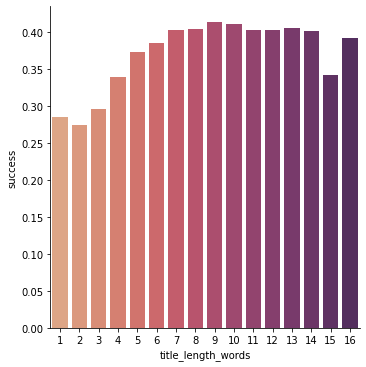

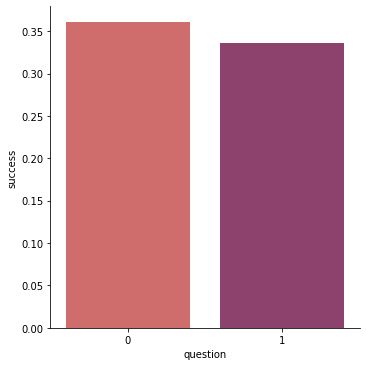

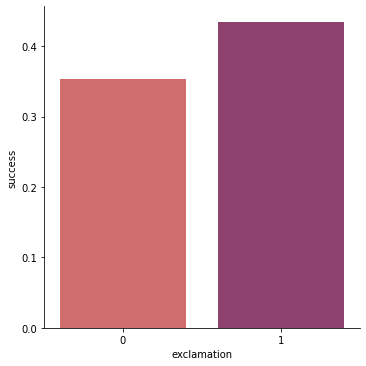

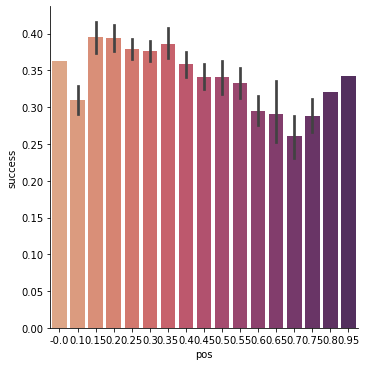

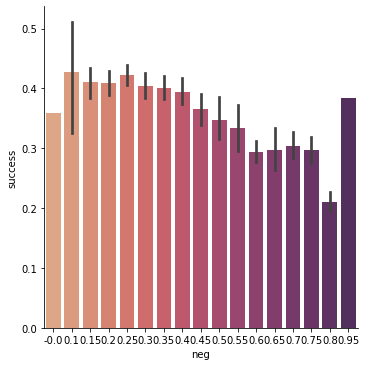

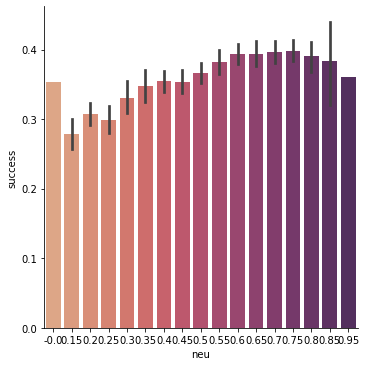

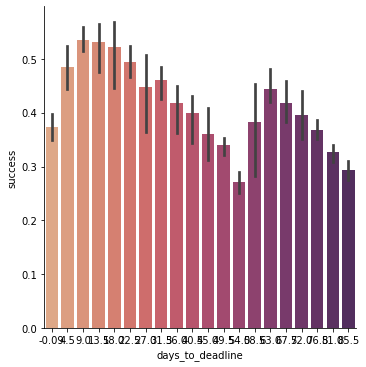

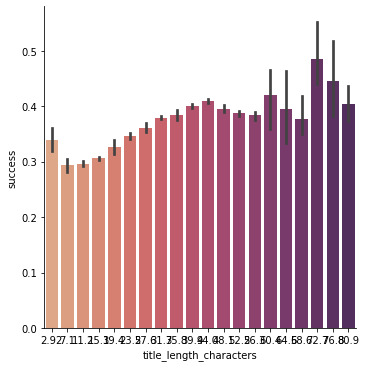

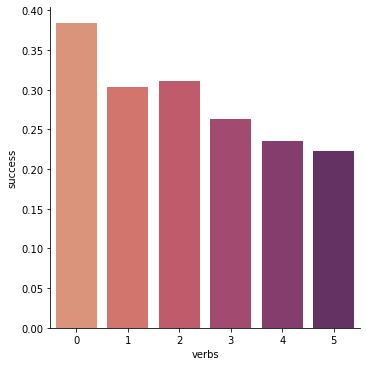

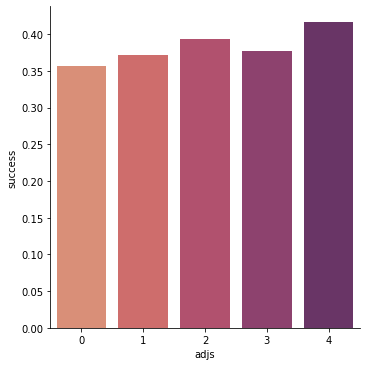

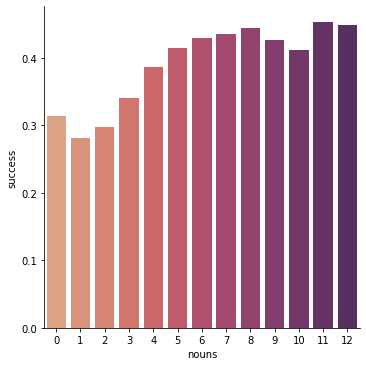

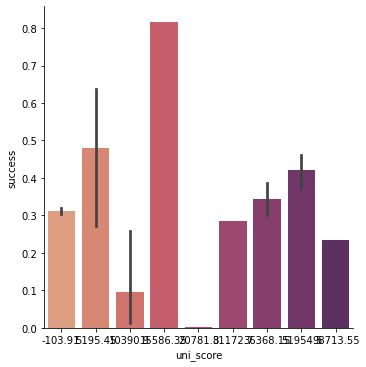

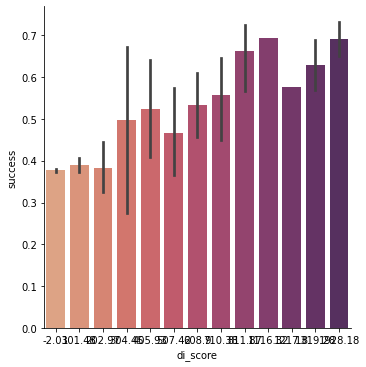

In [ ]:
values = ['title_length_words', 'question', 'exclamation', 'pos', 'neg', 'neu', 'days_to_deadline', 'title_length_characters', 'verbs', 'adjs', 'nouns', 'uni_score', 'di_score']
for value in values:
    vals = prep_data(value)
    sns.catplot(data=vals, x=value, y="success", kind="bar", palette="flare")

# Evaluation

In [ ]:
def score(y_true, y_pred):
    print("Accuracy: ", accuracy_score(y_true,y_pred))
    print("Balanced accuracy: ", balanced_accuracy_score(y_true,y_pred))
    print("F1 score: ", f1_score(y_true,y_pred))

Learning models bellow 

## Random Forests

### Bayesian hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(6, 20), # values of max_depth are integers from 6 to 20
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(100, 500)
    }

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = forest_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

forest_clf = RandomForestClassifier()
forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=10, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5)

forest_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration

best score: 0.681655213624141
best score: 0.6898893109678887
best score: 0.6898893109678887
best score: 0.6898893109678887
best score: 0.6900280279425783
best score: 0.6900280279425783
best score: 0.6941326276551851
best score: 0.6941326276551851
best score: 0.6941326276551851
best score: 0.6941326276551851


BayesSearchCV(cv=5, error_score='raise',
              estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                               class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               max_samples=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               n_estimators=100, n_jobs=...
                             'max_depth': Integer(low=6, high=20, prior='uniform', transform='ident

In [ ]:
forest_bayes_search.best_params_

OrderedDict([('bootstrap', True),
             ('max_depth', 18),
             ('max_features', 'auto'),
             ('min_samples_leaf', 8),
             ('min_samples_split', 9),
             ('n_estimators', 100)])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(6, 20), # values of max_depth are integers from 6 to 20
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(100, 500),
        "class_weight": Categorical([None,'balanced','balanced_subsample'])
    }

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = forest_bayes_search2.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

forest_clf2 = RandomForestClassifier()
forest_bayes_search2 = BayesSearchCV(forest_clf2, search_space, n_iter=30, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5)

forest_bayes_search2.fit(X_train2, y_train2, callback=on_step) # callback=on_step will print score after each iteration

best score: 0.6440842545563191
best score: 0.6440842545563191
best score: 0.6440842545563191
best score: 0.6440842545563191
best score: 0.6546480857057493
best score: 0.6546480857057493
best score: 0.6586104115981618
best score: 0.6586104115981618
best score: 0.6586104115981618
best score: 0.6586104115981618
best score: 0.6931438246048345
best score: 0.6931438246048345
best score: 0.6931473814503393
best score: 0.6931473814503393
best score: 0.6932932121160386
best score: 0.693734260958641
best score: 0.693734260958641
best score: 0.693734260958641
best score: 0.693734260958641
best score: 0.693734260958641
best score: 0.693734260958641


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best score: 0.693734260958641
best score: 0.693734260958641
best score: 0.693734260958641
best score: 0.693734260958641
best score: 0.693734260958641
best score: 0.693734260958641


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


best score: 0.693734260958641


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


best score: 0.693734260958641
best score: 0.693734260958641


BayesSearchCV(cv=5, error_score='raise',
              estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                               class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               max_samples=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               n_estimators=100, n_jobs=...
                             'max_depth': Integer(low=6, high=20, prior='uniform', transform='ident

In [ ]:
forest_bayes_search2.best_params_

OrderedDict([('bootstrap', False),
             ('class_weight', None),
             ('max_depth', 20),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 3),
             ('min_samples_split', 10),
             ('n_estimators', 375)])

### Model for X_train

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=False, 
                             max_depth=20, 
                             max_features='sqrt',
                             min_samples_leaf=3,
                             min_samples_split=10,
                             n_estimators=375, 
                             n_jobs=-1)
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)

Accuracy:  0.7015664347603398
Balanced accuracy:  0.6317951259418635
F1 score:  0.4797231936900067


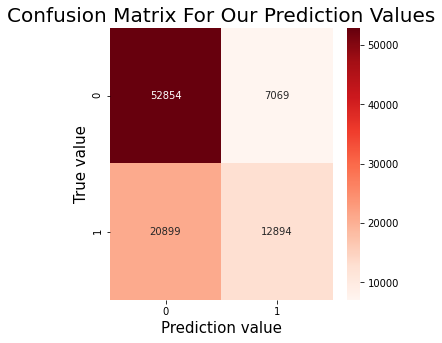

In [ ]:
score(y_test, y_preds)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test , y_preds)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

In [ ]:
sorted(zip(clf.feature_importances_, X_test.columns), key=lambda x: x[0], reverse=True)

[(0.1606905427392771, 'usd_goal_real'),
 (0.15989948442964538, 'goal'),
 (0.10996138372009093, 'days_to_deadline'),
 (0.09521348473468222, 'category_n'),
 (0.05842923911867227, 'title_length_characters'),
 (0.04791411101362074, 'title_length_words'),
 (0.04474582610596003, 'nouns'),
 (0.031576410092462766, 'verbs'),
 (0.027801014856611673, 'main_category_Music'),
 (0.02407897643647869, 'deadline_month'),
 (0.02395370845974689, 'launch_month'),
 (0.021511141463911688, 'main_category_Theater'),
 (0.018516156243372613, 'main_category_Technology'),
 (0.013404598353560171, 'main_category_Comics'),
 (0.012522729366573527, 'main_category_Fashion'),
 (0.0113480343617799, 'country_US'),
 (0.010785833240041155, 'main_category_Film & Video'),
 (0.010768268122485384, 'adjs'),
 (0.00943612911042063, 'exclamation'),
 (0.008704625694484113, 'main_category_Publishing'),
 (0.008476280611252229, 'main_category_Dance'),
 (0.00781085020158424, 'main_category_Food'),
 (0.007199621947696279, 'main_category_

### Model for X_train2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=200, criterion='entropy', n_jobs=-1)
clf2.fit(X_train2, y_train2)

score(y_test2, clf2.predict(X_test2))

Accuracy:  0.6937235904221264
Balanced accuracy:  0.6364498692447237
F1 score:  0.5037088268349615


Accuracy:  0.6937235904221264
Balanced accuracy:  0.6364498692447237
F1 score:  0.5037088268349615


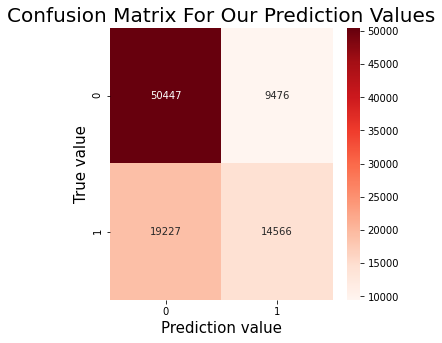

In [ ]:
y_preds2 = clf2.predict(X_test2)
score(y_test2, y_preds2)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test2 , y_preds2)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

In [ ]:
sorted(zip(clf2.feature_importances_, X_test2.columns), key=lambda x: x[0], reverse=True)

[(0.1334064928584701, 'usd_goal_real'),
 (0.12876728129194237, 'goal'),
 (0.10697556277316406, 'title_length'),
 (0.10070827954601827, 'days_to_deadline'),
 (0.040920083043633156, 'neu'),
 (0.04070317374488908, 'compound'),
 (0.033416912205649546, 'pos'),
 (0.017600956500488874, 'neg'),
 (0.011682122591324763, 'exclamation'),
 (0.006505103898444319, 'launch_season_spring'),
 (0.006096989588679654, 'launch_season_summer'),
 (0.006095302190626007, 'deadline_season_spring'),
 (0.006023311885522055, 'deadline_season_summer'),
 (0.005997316747452082, 'launch_season_winter'),
 (0.005948825710876009, 'deadline_season_autumn'),
 (0.005761694253706565, 'deadline_season_winter'),
 (0.005710830789544591, 'launch_season_autumn'),
 (0.005468105493547784, 'main_category_Music'),
 (0.005301586563893646, 'category_n_136'),
 (0.004877810280642069, 'deadline_month_6'),
 (0.004866112564425328, 'launch_month_5'),
 (0.0048233775004833095, 'launch_month_3'),
 (0.0047401113138958164, 'deadline_month_3'),
 (0

### Model for X_train duplicated

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clfd = RandomForestClassifier(bootstrap=False,
             max_depth=20,
             max_features='sqrt',
             min_samples_leaf=3,
             min_samples_split=10,
             n_estimators=375)
clfd.fit(X_traind, y_traind)

RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=375)

Accuracy:  0.6734709121174612
Balanced accuracy:  0.6738412361044492
F1 score:  0.5985859142366168


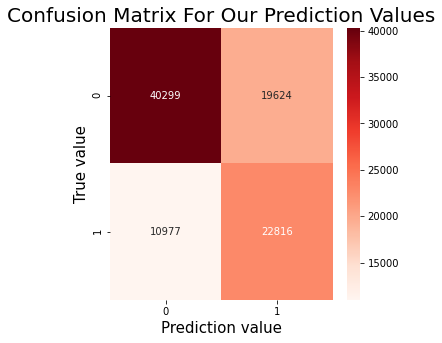

In [ ]:
y_predsd = clfd.predict(X_test)
score(y_test, y_predsd)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test , y_predsd)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

## Lightgbm

### Bayesian hyperparameter tuning

In [ ]:
import lightgbm
search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(-10, -1), # values of max_depth are integers from 6 to 20
        "n_estimators": Integer(100, 500),
        "class_weight": Categorical([None,'balanced']),
        "num_leaves": Integer(20,50),
        "reg_alpha": Real(0,1),
        "reg_lambda": Real(0,1),
        "importance_type": Categorical(['gain','split'])
    }

def on_step(optim_result):
    score = lgbm_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

lgbm = lightgbm.LGBMClassifier()
lgbm_bayes_search = BayesSearchCV(lgbm, search_space, n_iter=30, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5)

lgbm_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration

best score: 0.7040491129227311
best score: 0.7040491129227311
best score: 0.704806721015266
best score: 0.704806721015266
best score: 0.704806721015266
best score: 0.704806721015266
best score: 0.704806721015266
best score: 0.704981006445004
best score: 0.704981006445004
best score: 0.704981006445004
best score: 0.704981006445004
best score: 0.704981006445004
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692
best score: 0.7051019391921692


BayesSearchCV(cv=5, error_score='raise',
              estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                       colsample_bytree=1.0,
                                       importance_type='split',
                                       learning_rate=0.1, max_depth=-1,
                                       min_child_samples=20,
                                       min_child_weight=0.001,
                                       min_split_gain=0.0, n_estimators=100,
                                       n_jobs=-1, num_leaves=31, objective=None,
                                       random_state=None, reg_alpha=0.0,
                                       reg_lambda=0.0, silen...
                             'max_depth': Integer(low=-10, high=-1, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='identity'),
                             'num_leaves': 

In [ ]:
lgbm_bayes_search.best_params_

OrderedDict([('bootstrap', True),
             ('class_weight', None),
             ('importance_type', 'gain'),
             ('max_depth', -1),
             ('n_estimators', 500),
             ('num_leaves', 50),
             ('reg_alpha', 1.0),
             ('reg_lambda', 1.0)])

In [ ]:
import lightgbm
search_space = {
        "bootstrap": Categorical([True]),
        "max_depth": Integer(-10, 0),
        "n_estimators": Integer(500,600),
        "class_weight": Categorical([None,'balanced']),
        "num_leaves": Integer(30,70),
        "reg_alpha": Real(1,100),
        "reg_lambda": Real(1,100),
        "importance_type": Categorical(['gain'])
    }

def on_step(optim_result):
    score = lgbm_bayes_search.best_score_
    print("best score: %s" % score)
    print(lgbm_bayes_search.best_params_)
    if score >= 0.98:
        print('Interrupting!')
        return True

lgbm = lightgbm.LGBMClassifier()
lgbm_bayes_search = BayesSearchCV(lgbm, search_space, n_iter=30, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5)

lgbm_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration

best score: 0.6746340005975501
OrderedDict([('bootstrap', True), ('class_weight', 'balanced'), ('importance_type', 'gain'), ('max_depth', -2), ('n_estimators', 581), ('num_leaves', 59), ('reg_alpha', 94.45566696227138), ('reg_lambda', 67.22256651099123)])
best score: 0.7027579780044674
OrderedDict([('bootstrap', True), ('class_weight', None), ('importance_type', 'gain'), ('max_depth', -7), ('n_estimators', 546), ('num_leaves', 68), ('reg_alpha', 76.86254842773772), ('reg_lambda', 64.18582034302096)])
best score: 0.7048885284618778
OrderedDict([('bootstrap', True), ('class_weight', None), ('importance_type', 'gain'), ('max_depth', -6), ('n_estimators', 560), ('num_leaves', 43), ('reg_alpha', 30.98219742156608), ('reg_lambda', 73.45237747316209)])
best score: 0.7048885284618778
OrderedDict([('bootstrap', True), ('class_weight', None), ('importance_type', 'gain'), ('max_depth', -6), ('n_estimators', 560), ('num_leaves', 43), ('reg_alpha', 30.98219742156608), ('reg_lambda', 73.452377473162

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best score: 0.7054540668971503
OrderedDict([('bootstrap', True), ('class_weight', None), ('importance_type', 'gain'), ('max_depth', 0), ('n_estimators', 501), ('num_leaves', 33), ('reg_alpha', 20.544947756214327), ('reg_lambda', 91.74709164772239)])
best score: 0.7054540668971503
OrderedDict([('bootstrap', True), ('class_weight', None), ('importance_type', 'gain'), ('max_depth', 0), ('n_estimators', 501), ('num_leaves', 33), ('reg_alpha', 20.544947756214327), ('reg_lambda', 91.74709164772239)])


BayesSearchCV(cv=5, error_score='raise',
              estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                       colsample_bytree=1.0,
                                       importance_type='split',
                                       learning_rate=0.1, max_depth=-1,
                                       min_child_samples=20,
                                       min_child_weight=0.001,
                                       min_split_gain=0.0, n_estimators=100,
                                       n_jobs=-1, num_leaves=31, objective=None,
                                       random_state=None, reg_alpha=0.0,
                                       reg_lambda=0.0, silen...
                             'max_depth': Integer(low=-10, high=0, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=500, high=600, prior='uniform', transform='identity'),
                             'num_leaves': I

In [ ]:
lgbm_bayes_search.best_params_

OrderedDict([('bootstrap', True),
             ('class_weight', None),
             ('importance_type', 'gain'),
             ('max_depth', 0),
             ('n_estimators', 501),
             ('num_leaves', 33),
             ('reg_alpha', 20.544947756214327),
             ('reg_lambda', 91.74709164772239)])

### Model for X_train

In [ ]:
import lightgbm
lgbm = lightgbm.LGBMClassifier(
                bootstrap=True,
                n_estimators=501,
                num_leaves=33,
                max_depth=0,
                reg_alpha=20.545,
                reg_lambda=91.747,
                importance_type = 'gain'
               )

lgbm.fit(X_train, y_train)
y_preds = lgbm.predict(X_test)

Accuracy:  0.7095800076827863
Balanced accuracy:  0.6580689116830917
F1 score:  0.5403077338828179


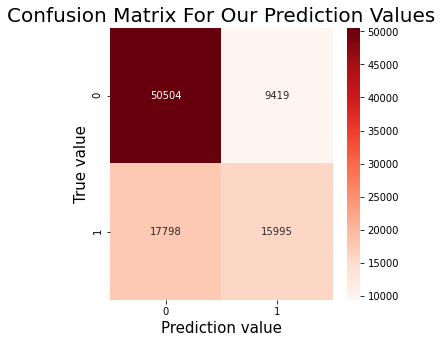

In [ ]:
score(y_test, y_preds)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test , y_preds)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

### Model for X_train2

In [ ]:
import lightgbm
lgbm2 = lightgbm.LGBMClassifier(
                bootstrap=True,
                n_estimators=501,
                num_leaves=33,
                max_depth=0,
                reg_alpha=20.545,
                reg_lambda=91.747,
                importance_type = 'gain'
               )

lgbm2.fit(X_train2, y_train2)
y_preds2 = lgbm2.predict(X_test2)

Accuracy:  0.7102202398736609
Balanced accuracy:  0.6592728136876754
F1 score:  0.5425419017939863


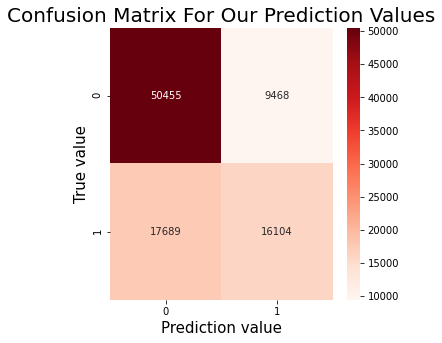

In [ ]:
score(y_test2, y_preds2)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test2 , y_preds2)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

### Model for X_train duplicated

In [ ]:
import lightgbm
lgbmd = lightgbm.LGBMClassifier(
                bootstrap=True,
                n_estimators=501,
                num_leaves=33,
                max_depth=0,
                reg_alpha=20.545,
                reg_lambda=91.747,
                importance_type = 'gain'
               )

lgbmd.fit(X_traind, y_traind)
y_predsd = lgbmd.predict(X_test)

Accuracy:  0.682839643177259
Balanced accuracy:  0.6894451206660775
F1 score:  0.6185495566021997


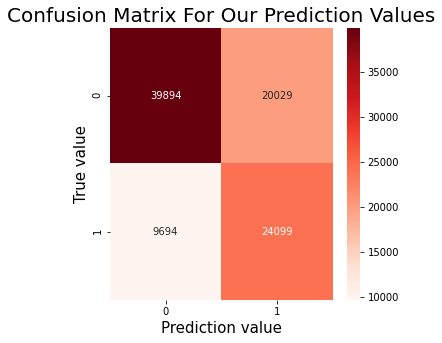

In [ ]:
score(y_test, y_predsd)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test, y_predsd)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

## XGBoost

### Bayesian hyperparameter tuning

In [ ]:
import xgboost as xgb
search_space = {
    "n_estimators": Integer(100,200),
    "max_depth": Integer(4,14),
    "max_delta_step": Real(8,30),
    "lambda": Real(20,100),
    "alpha": Real(0,2),
    "objective": Categorical(["reg:squarederror","reg:logistic","binary:hinge"])
    }

def on_step(optim_result):
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    print(xgb_bayes_search.best_params_)
    if score >= 0.98:
        print('Interrupting!')
        return True

xgb = xgb.XGBClassifier()
xgb_bayes_search = BayesSearchCV(xgb, search_space, n_iter=20, scoring="accuracy", n_jobs=-1, cv=3)

xgb_bayes_search.fit(X_train, y_train, callback=on_step)

best score: 0.7110809964858367
OrderedDict([('alpha', 1.9687942276507928), ('lambda', 34.084199885392664), ('max_delta_step', 13.335922720306701), ('max_depth', 8), ('n_estimators', 172), ('objective', 'reg:logistic')])
best score: 0.7110809964858367
OrderedDict([('alpha', 1.9687942276507928), ('lambda', 34.084199885392664), ('max_delta_step', 13.335922720306701), ('max_depth', 8), ('n_estimators', 172), ('objective', 'reg:logistic')])
best score: 0.7110809964858367
OrderedDict([('alpha', 1.9687942276507928), ('lambda', 34.084199885392664), ('max_delta_step', 13.335922720306701), ('max_depth', 8), ('n_estimators', 172), ('objective', 'reg:logistic')])
best score: 0.7110809964858367
OrderedDict([('alpha', 1.9687942276507928), ('lambda', 34.084199885392664), ('max_delta_step', 13.335922720306701), ('max_depth', 8), ('n_estimators', 172), ('objective', 'reg:logistic')])
best score: 0.7110809964858367
OrderedDict([('alpha', 1.9687942276507928), ('lambda', 34.084199885392664), ('max_delta_s

KeyboardInterrupt: ignored

In [ ]:
xgb_bayes_search.best_params_

OrderedDict([('alpha', 1.9793724523102965),
             ('lambda', 21.96811473848601),
             ('max_delta_step', 12.806433561300526),
             ('max_depth', 6),
             ('n_estimators', 196),
             ('objective', 'reg:logistic')])

### Model for X_train

In [ ]:
import xgboost as xgb
bst = xgb.XGBClassifier(n_jobs=-1, 
                        n_estimators=196, 
                        booster='gbtree', 
                        objective='reg:logistic',
                        alpha=1.979,
                        reg_lambda=21.968,
                        max_depth=6,
                        max_delta_step=12.806) 
bst.fit(X_train, y_train)
y_preds = bst.predict(X_test)

Accuracy:  0.7087690469076785
Balanced accuracy:  0.6534410247221958
F1 score:  0.5297958480489275


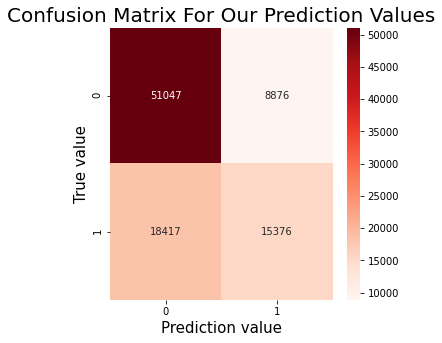

In [ ]:
score(y_test, y_preds)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test , y_preds)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

### Model for X_train2

In [ ]:
import xgboost as xgb
bst2 = xgb.XGBClassifier(n_jobs=-1, 
                        n_estimators=300, 
                        booster='gbtree', 
                        objective='reg:logistic',
                        alpha=1.979,
                        reg_lambda=21.968,
                        max_depth=6,
                        max_delta_step=12.806) 
bst2.fit(X_train2, y_train2)
y_preds2 = bst2.predict(X_test2)

Accuracy:  0.7091531862222032
Balanced accuracy:  0.6545156408738535
F1 score:  0.5320606362340985


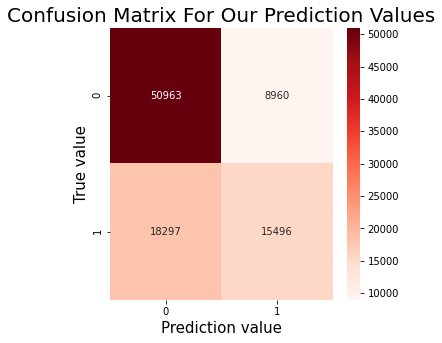

In [ ]:
score(y_test2, y_preds2)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test2 , y_preds2)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

### Model for X_train duplicated

In [ ]:
import xgboost as xgb
bstd = xgb.XGBClassifier(n_jobs=-1, 
                        n_estimators=300, 
                        booster='gbtree', 
                        objective='reg:logistic',
                        alpha=1.979,
                        reg_lambda=21.968,
                        max_depth=6,
                        max_delta_step=12.806) 
bstd.fit(X_traind, y_traind)
y_predsd = bstd.predict(X_test)

Accuracy:  0.6820606940116949
Balanced accuracy:  0.6885005056837807
F1 score:  0.6174605212479137


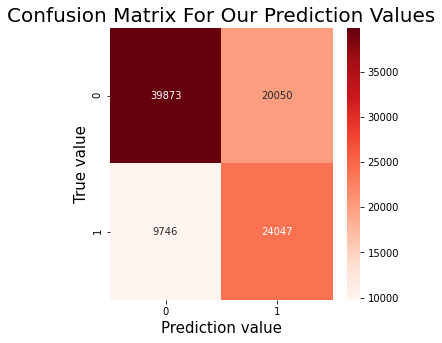

In [ ]:
score(y_test, y_predsd)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test , y_predsd)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

## CatBoost

### Bayesian hyperparameter tuning

In [ ]:
import catboost as cb
search_space = {
    "n_estimators": Integer(300,700),
    "max_depth": Integer(2,16),
    "reg_lambda": Real(1,50),
    "auto_class_weights": Categorical(['Balanced','SqrtBalanced'])
    }

def on_step(optim_result):
    score = cboost_bayes_search.best_score_
    print("best score: %s" % score)
    print(cboost_bayes_search.best_params_)
    if score >= 0.98:
        print('Interrupting!')
        return True

cboost = cb.CatBoostClassifier()
cboost_bayes_search = BayesSearchCV(cboost, search_space, n_iter=50, scoring="accuracy", n_jobs=-1, cv=3)

cboost_bayes_search.fit(X_train3, y_train3, callback=on_step)

In [ ]:
cboost_bayes_search.best_params_

In [ ]:
import catboost as cb
search_space = {
    "n_estimators": Integer(300,700),
    "max_depth": Integer(2,16),
    "reg_lambda": Real(1,50)
    }

def on_step(optim_result):
    score = cboost_bayes_search.best_score_
    print("best score: %s" % score)
    print(cboost_bayes_search.best_params_)
    if score >= 0.98:
        print('Interrupting!')
        return True

cboost = cb.CatBoostClassifier()
cboost_bayes_search = BayesSearchCV(cboost, search_space, n_iter=50, scoring="accuracy", n_jobs=-1, cv=3)

cboost_bayes_search.fit(X_train3, y_train3, callback=on_step)

In [ ]:
cboost_bayes_search.best_params_

### Model for X_train3

In [ ]:
import catboost as cb
cboosted = cb.CatBoostClassifier(iterations=189,
                                depth=11,
                                reg_lambda=7.88,
                                verbose=False)
cboosted.fit(X_train3, y_train3)
y_preds = cboosted.predict(X_test3)

Accuracy:  0.7014063767126211
Balanced accuracy:  0.6350830321317391
F1 score:  0.48963139944190115


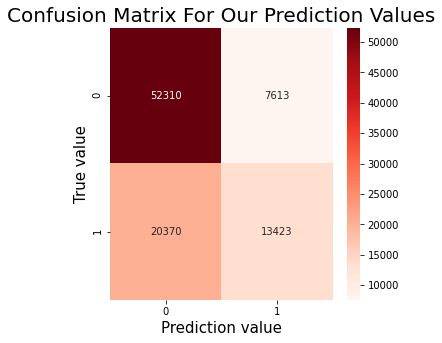

In [ ]:
score(y_test3, y_preds)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test3 , y_preds)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()

### Model for X_train3 duplicated

In [ ]:
import catboost as cb
cboostedd = cb.CatBoostClassifier(iterations=189,
                                depth=11,
                                reg_lambda=7.88,
                                verbose=False)
cboostedd.fit(X_train3d, y_train3d)
y_predsd = cboostedd.predict(X_test3)

Accuracy:  0.6655853856331896
Balanced accuracy:  0.6748753345307432
F1 score:  0.6043129134892177


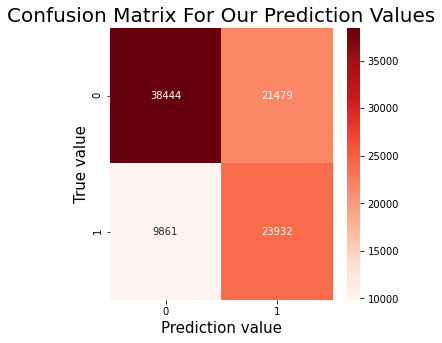

In [ ]:
score(y_test3, y_predsd)
plt.figure(figsize=(5,5))
cf = confusion_matrix(y_test3 , y_predsd)
sns.heatmap(cf,fmt='2d',annot=True,cmap='Reds')
plt.xlabel('Prediction value',fontsize=15)
plt.ylabel('True value',fontsize=15)
plt.title('Confusion Matrix For Our Prediction Values',fontsize=20)
plt.show()